# Import the libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from  scipy import ndimage
from cv2 import cv2
from matplotlib.image import imread,imsave
import plotly.figure_factory as ff
import plotly.graph_objects as go
import math
import tensorflow as tf

In [18]:
h = 224
w = 224

Import the data

In [3]:
cd C:\Users\venka\OneDrive\Desktop\BTP\Data\source_doublet_vortex\train_data\val

C:\Users\venka\OneDrive\Desktop\BTP\Data\source_doublet_vortex\train_data\val


In [9]:
X_val = np.load('raw_vel_files.npy')

In [10]:
X_val.shape

(200, 224, 224, 3)

In [11]:
df = pd.read_csv('strength_details.csv')

In [12]:
df

imagename                                               bbox  \
0      image0.png  0 0.3654708520179372 0.3834080717488789 0.12 0...   
1      image1.png  2 0.16457399103139014 0.1681614349775785 0.12 ...   
2      image2.png  0 0.8174887892376681 0.5556053811659193 0.12 0...   
3      image3.png  2 0.2434977578475336 0.14304932735426007 0.12 ...   
4      image4.png  1 0.6130044843049327 0.26502242152466365 0.12 ...   
..            ...                                                ...   
195  image195.png  1 0.7887892376681614 0.7098654708520179 0.12 0...   
196  image196.png  1 0.6381165919282511 0.46591928251121073 0.12 ...   
197  image197.png  0 0.7780269058295964 0.48744394618834086 0.12 ...   
198  image198.png  1 0.13228699551569506 0.27578475336322866 0.12...   
199  image199.png  0 0.8533632286995516 0.30448430493273543 0.12 ...   

                        strength_val  
0               54 62 69 51 69 61 58  
1                              70 53  
2                                 67  
3                              61 65  
4                                 51  
..                               ...  
195       56 55 69 51 55 71 68 61 60  
196        45 -59 55 54 -87 48 69 38  
197  77 72 -61 98 70 46 53 41 -89 66  
198                         53 54 61  
199  -88 69 73 62 48 -73 61 53 65 63  

[200 rows x 3 columns]

In [13]:
cd C:\Users\venka\OneDrive\Desktop\BTP\Run_results

C:\Users\venka\OneDrive\Desktop\BTP\Run_results


# Load the models

In [15]:
model_sink = tf.keras.models.load_model('source_sink_weights.h5')

In [16]:
model_doublet = tf.keras.models.load_model('doublet_weights.h5')

In [17]:
model_vortex = tf.keras.models.load_model('vortex_weights.h5')

In [31]:
m1 = 0.43784698
b1 = 0.19821577
m2 = 0.35163331
b2 = 0.24319486
m3 = 0.28876907
b3 = 0.26025826

<ipython-input-88-1382abf759a6>:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,2)


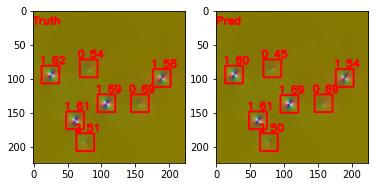

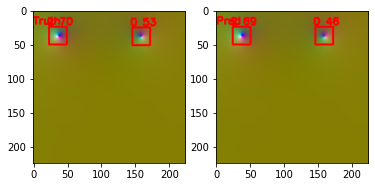

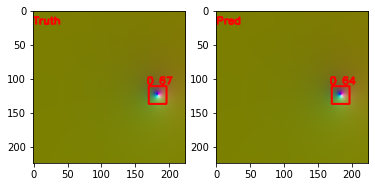

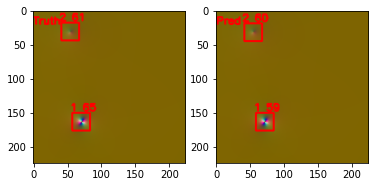

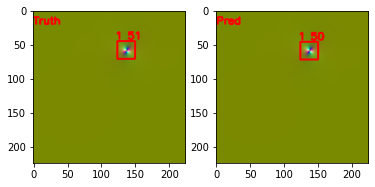

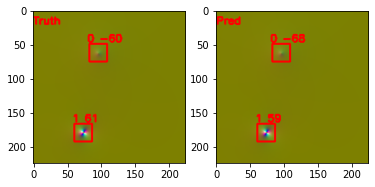

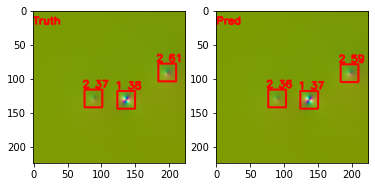

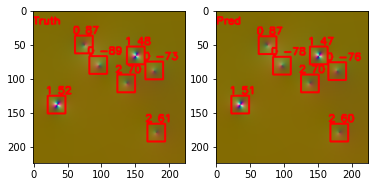

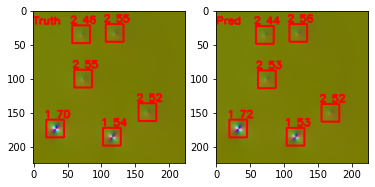

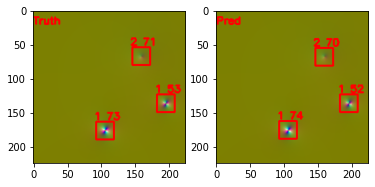

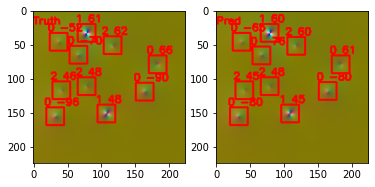

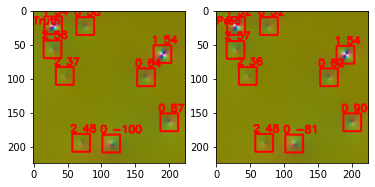

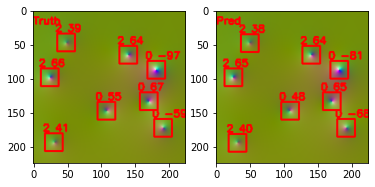

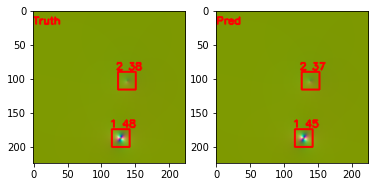

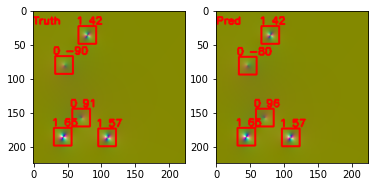

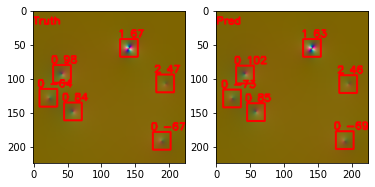

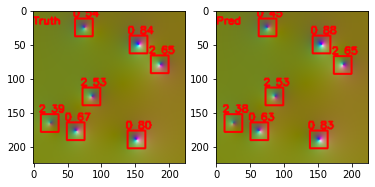

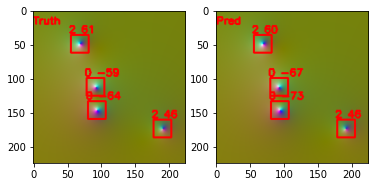

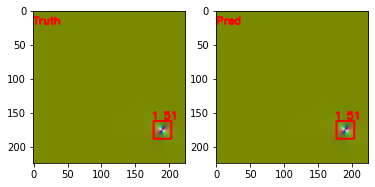

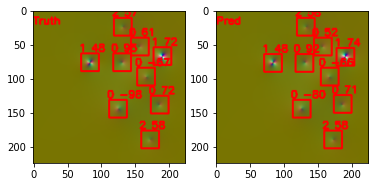

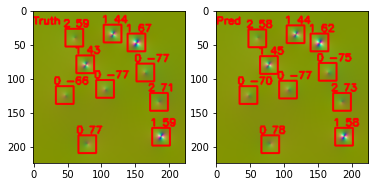

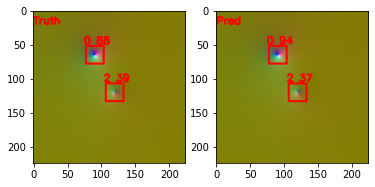

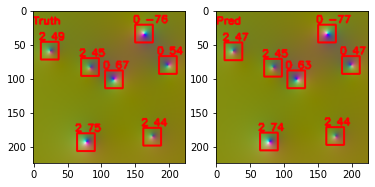

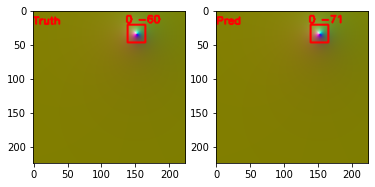

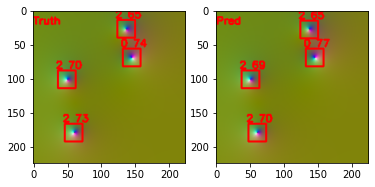

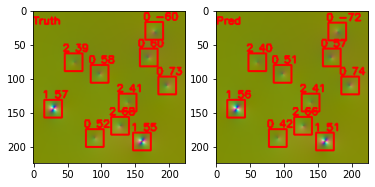

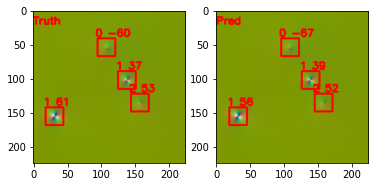

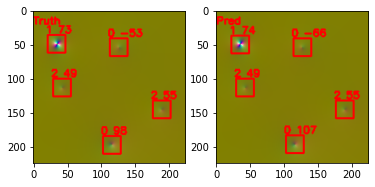

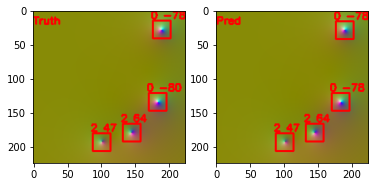

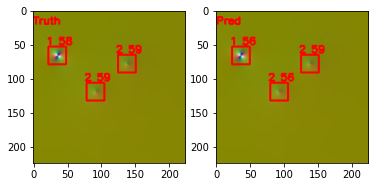

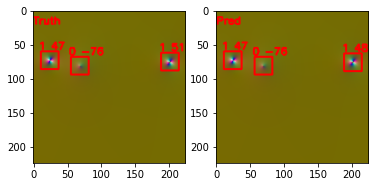

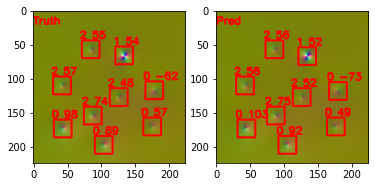

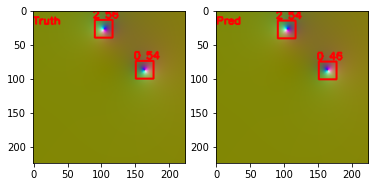

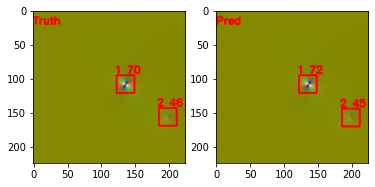

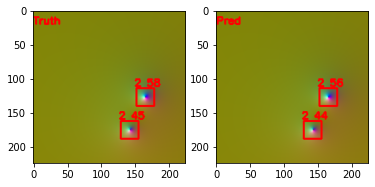

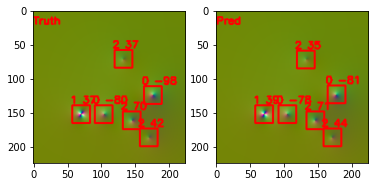

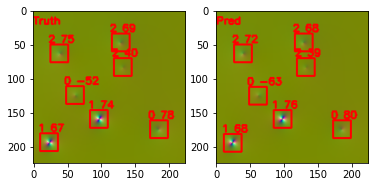

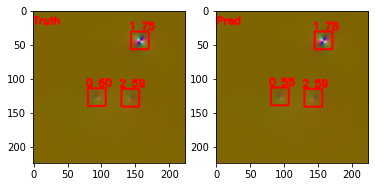

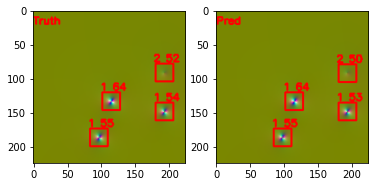

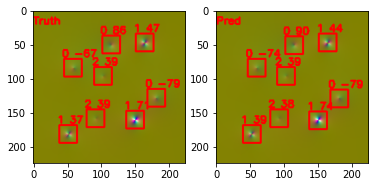

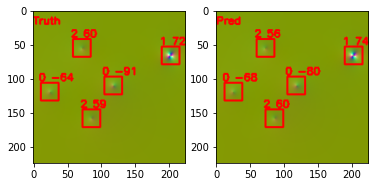

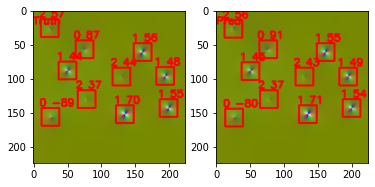

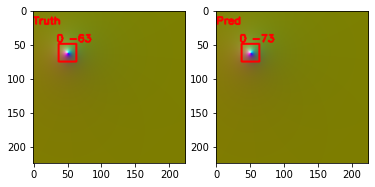

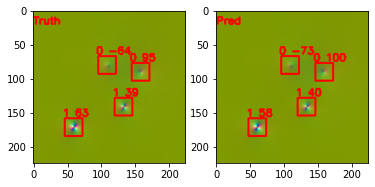

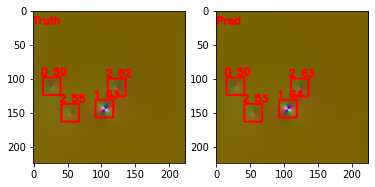

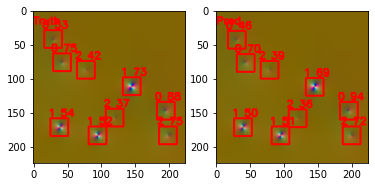

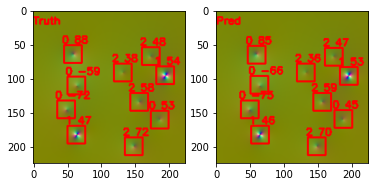

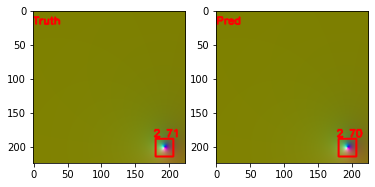

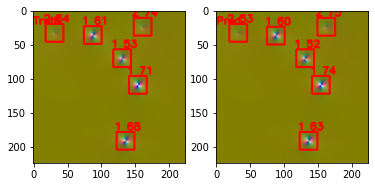

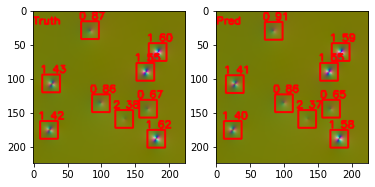

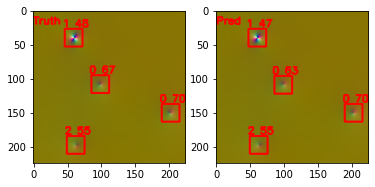

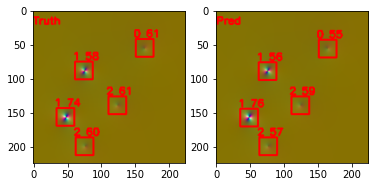

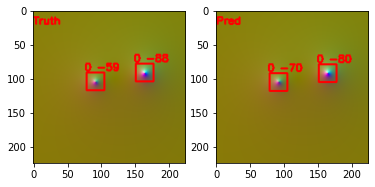

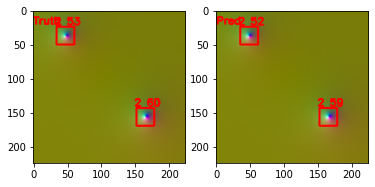

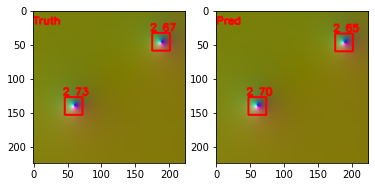

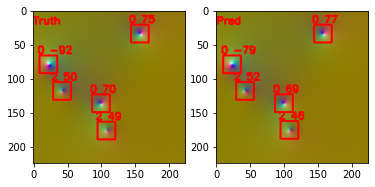

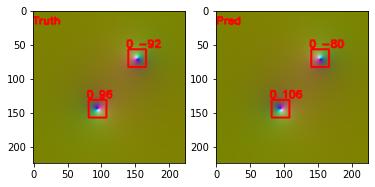

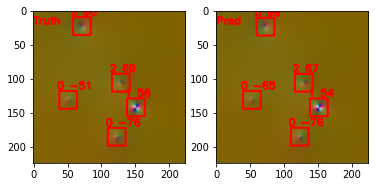

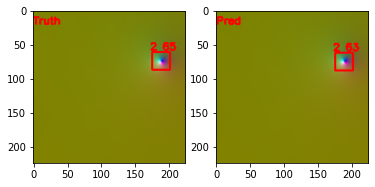

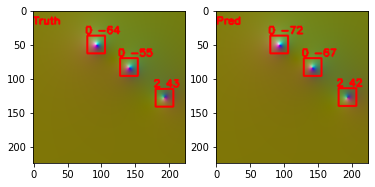

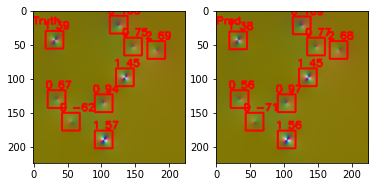

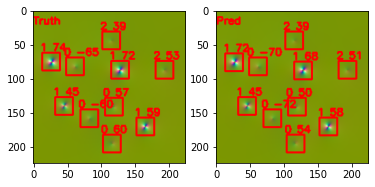

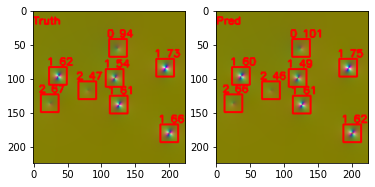

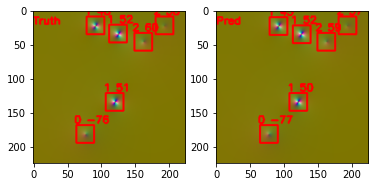

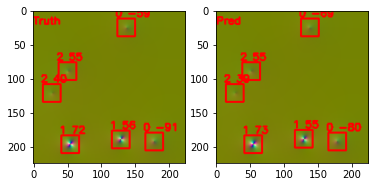

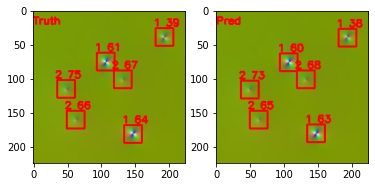

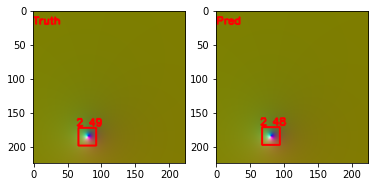

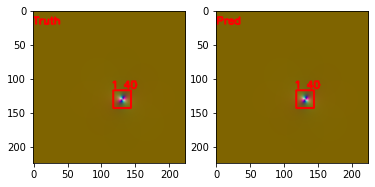

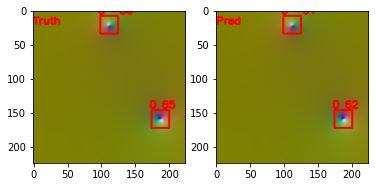

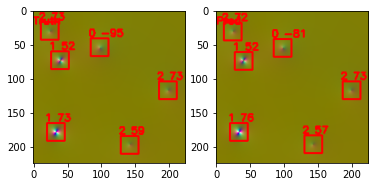

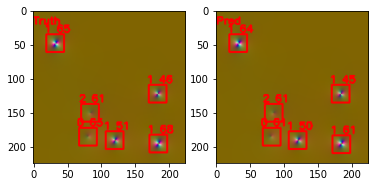

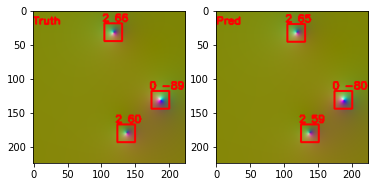

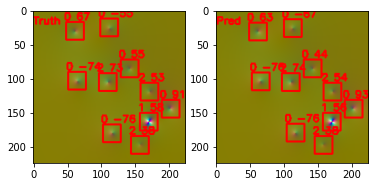

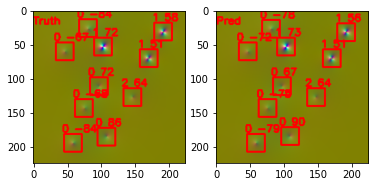

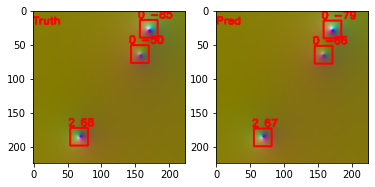

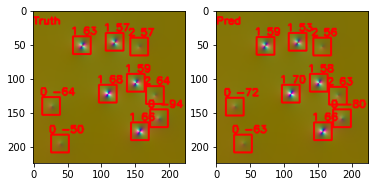

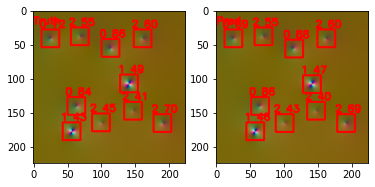

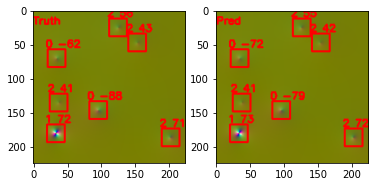

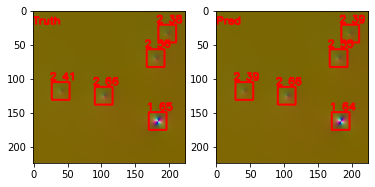

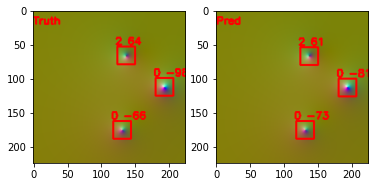

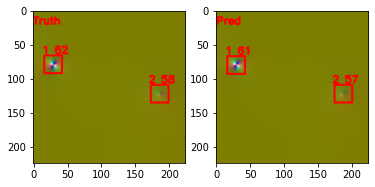

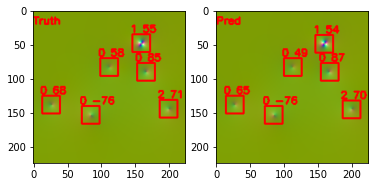

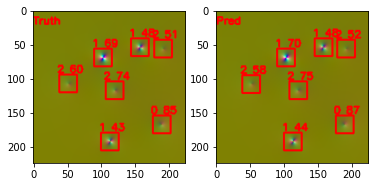

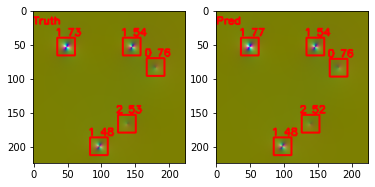

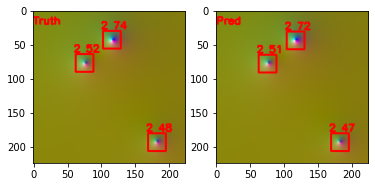

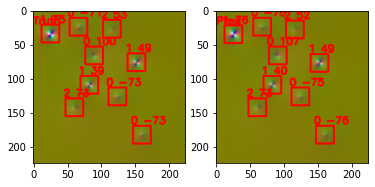

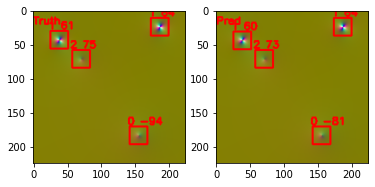

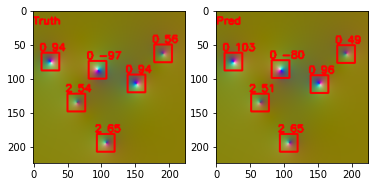

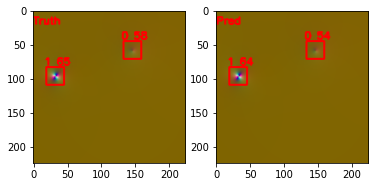

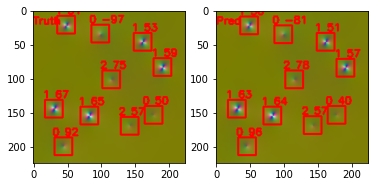

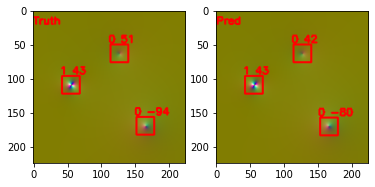

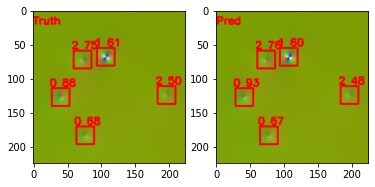

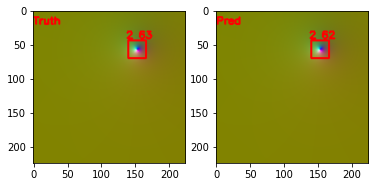

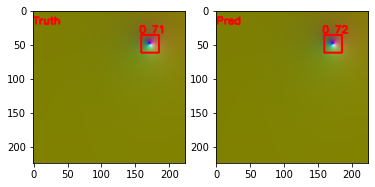

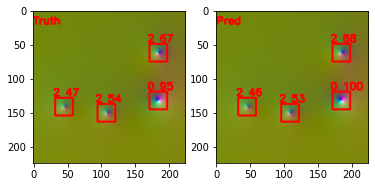

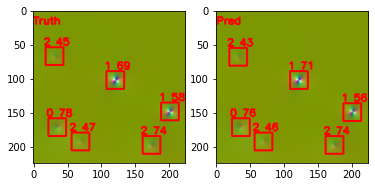

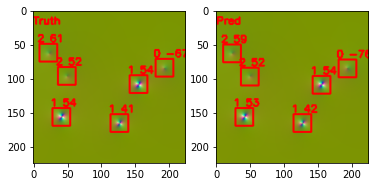

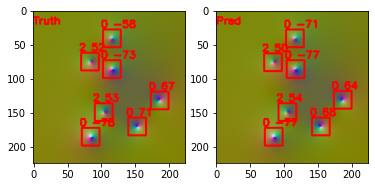

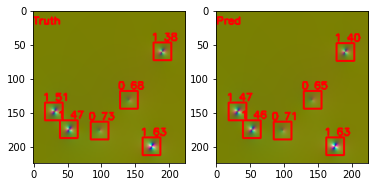

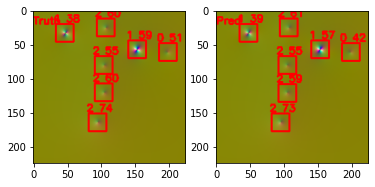

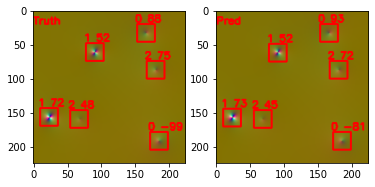

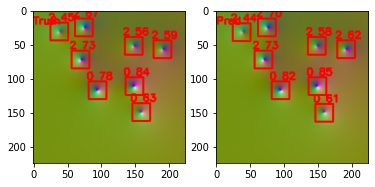

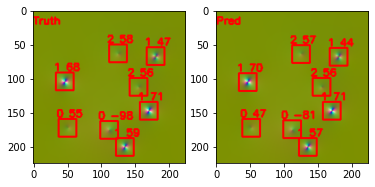

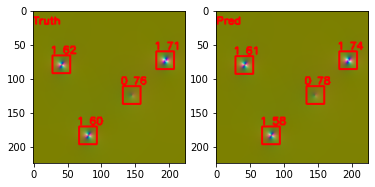

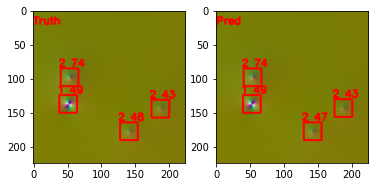

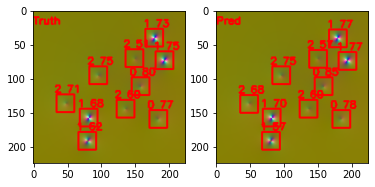

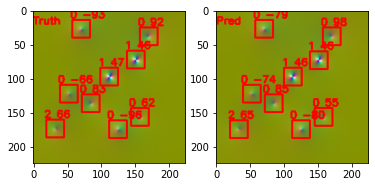

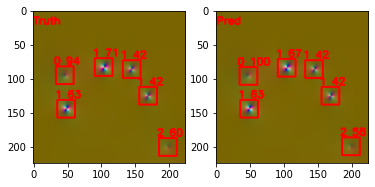

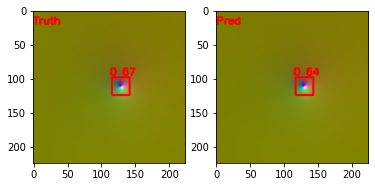

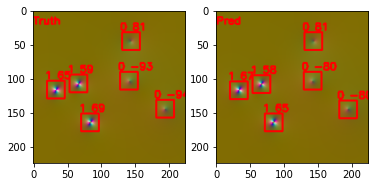

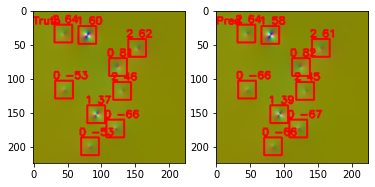

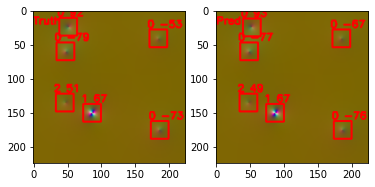

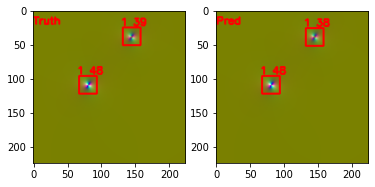

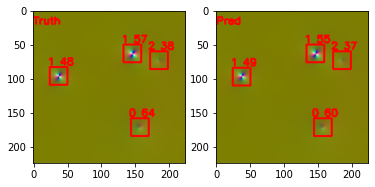

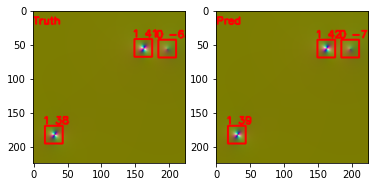

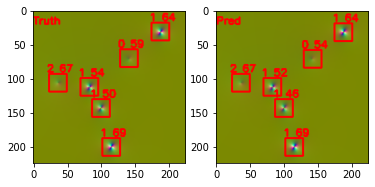

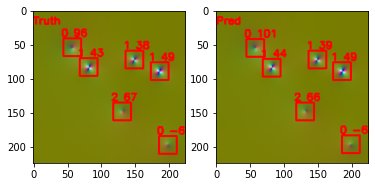

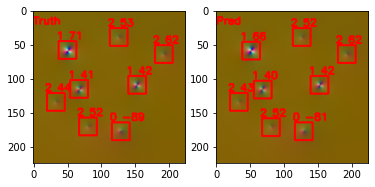

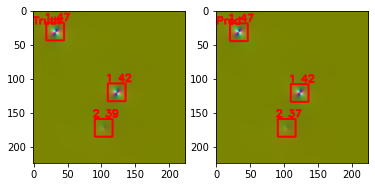

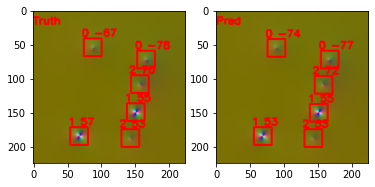

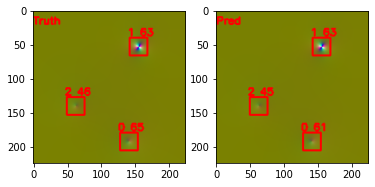

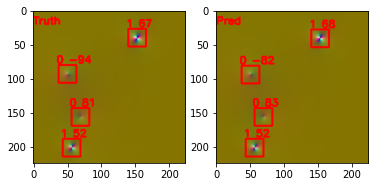

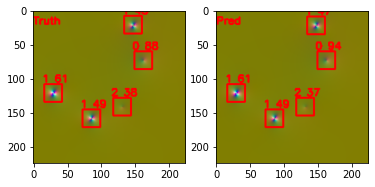

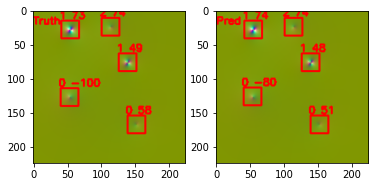

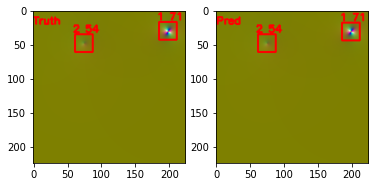

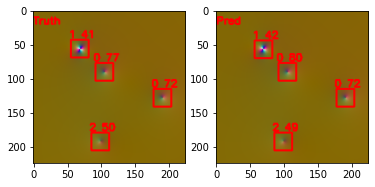

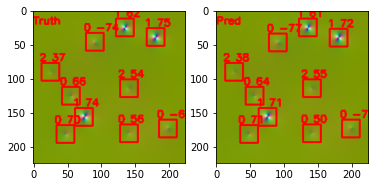

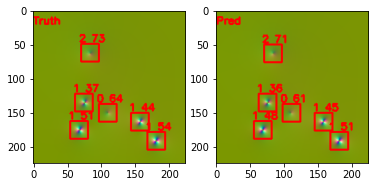

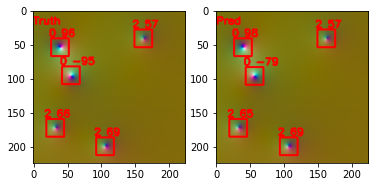

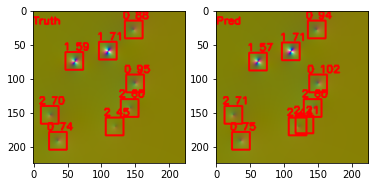

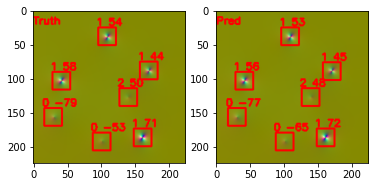

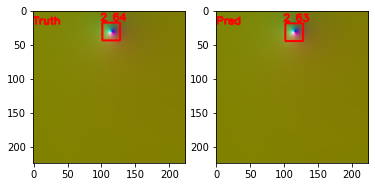

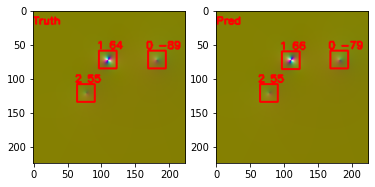

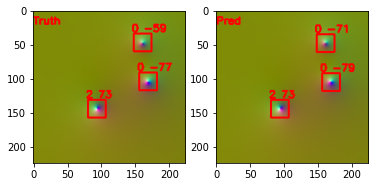

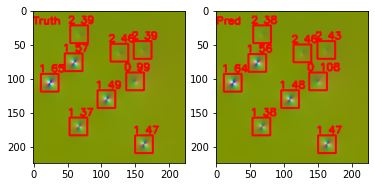

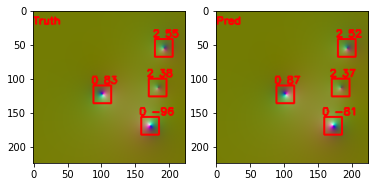

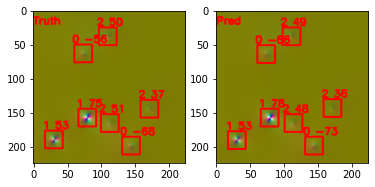

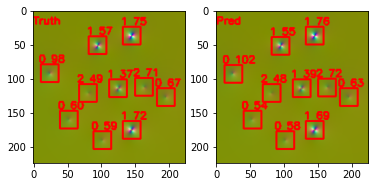

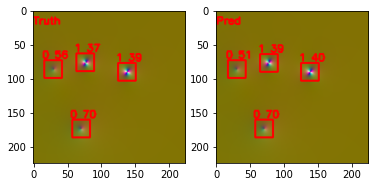

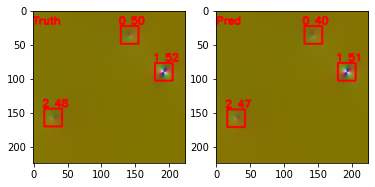

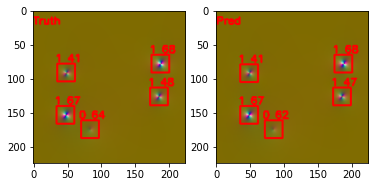

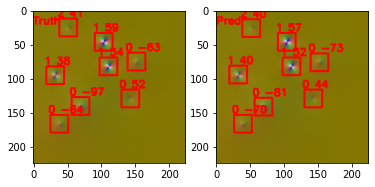

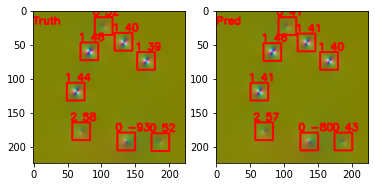

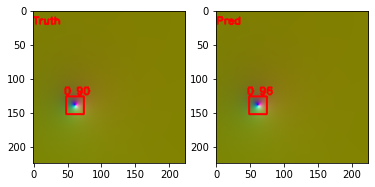

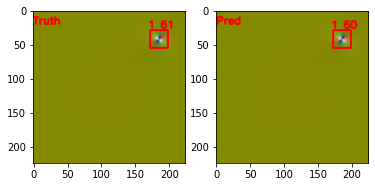

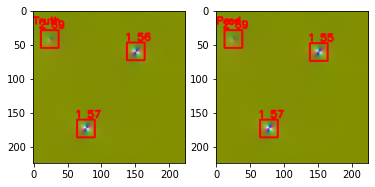

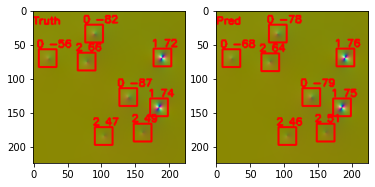

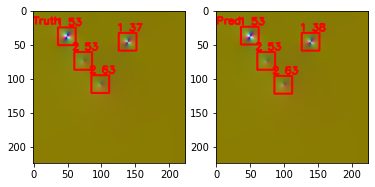

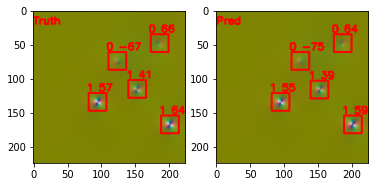

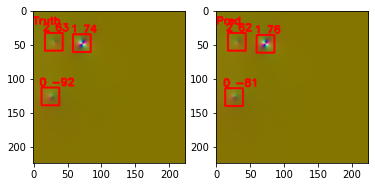

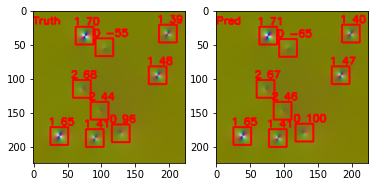

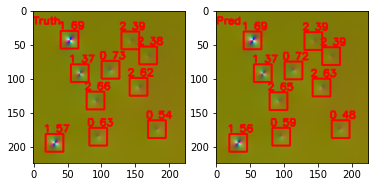

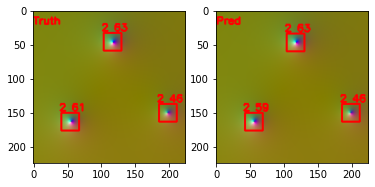

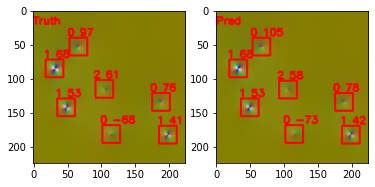

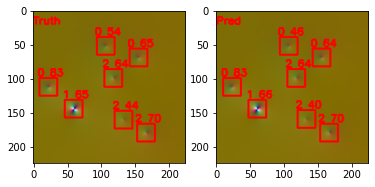

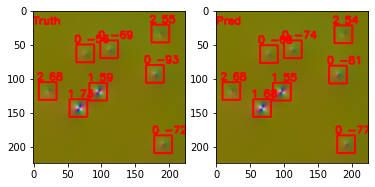

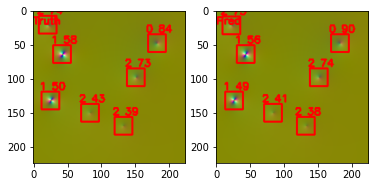

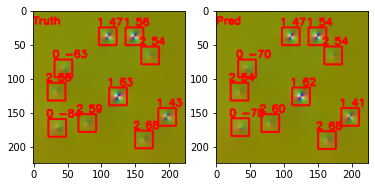

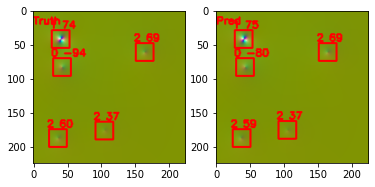

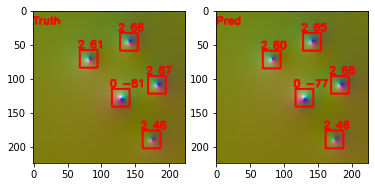

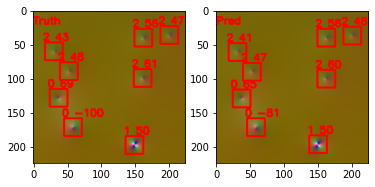

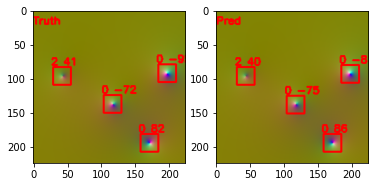

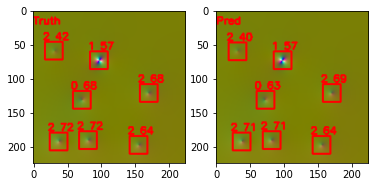

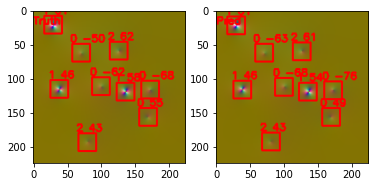

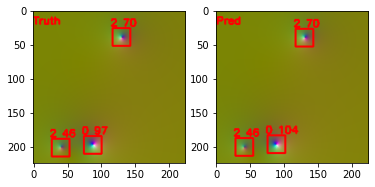

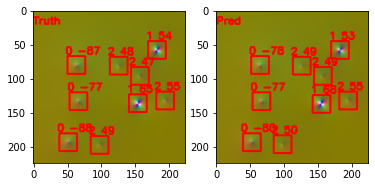

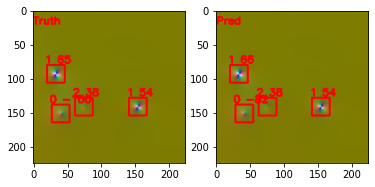

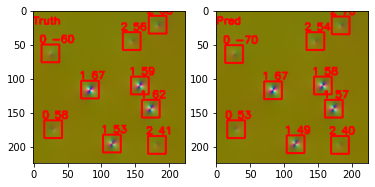

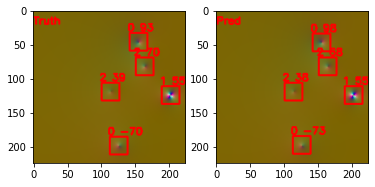

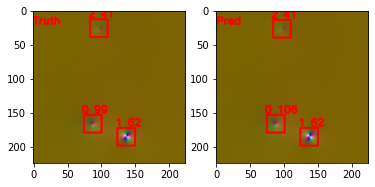

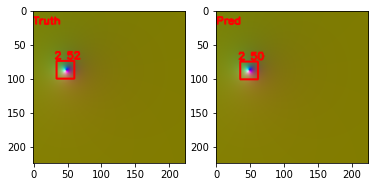

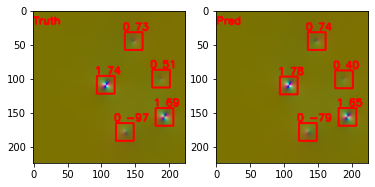

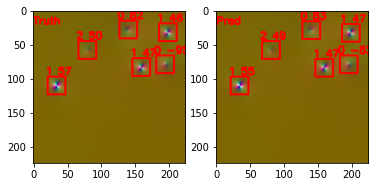

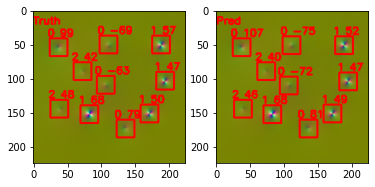

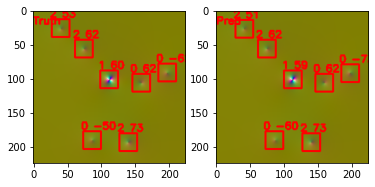

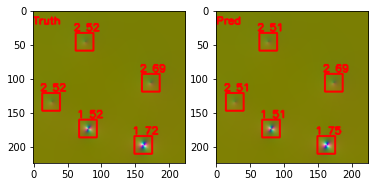

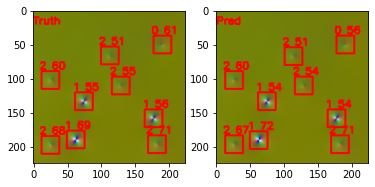

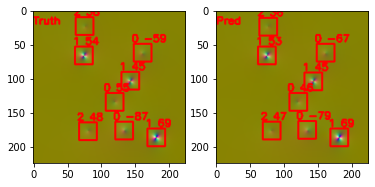

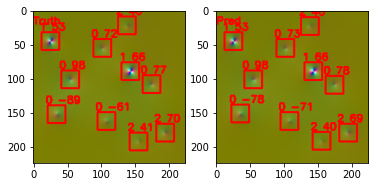

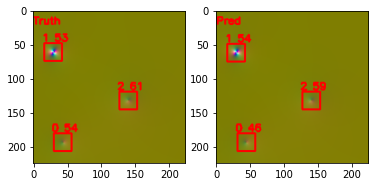

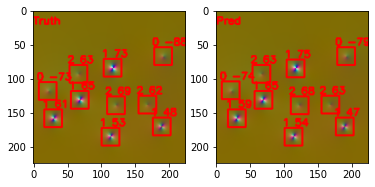

In [88]:
for i,image in enumerate(df['imagename'].tolist()):
    try:
        lines1 = df['bbox'].tolist()[i]
        l2 = df['strength_val'].tolist()[i]
        l2 = l2.split()

        lines1 = lines1.split('\n')

        while('' in lines1):
            lines1.remove('')

        file = open('val data boxes/'+image.split('.')[0]+'.txt')
        lines = file.readlines()
        file.close()

        U = X_val[i][:,:,0]
        V = X_val[i][:,:,1]
        T = X_val[i][:,:,2]

        U=(U-U.min())/(U.max()-U.min())
        V=(V-V.min())/(V.max()-V.min())
        T=(T-T.min())/(T.max()-T.min())

        rgb=np.dstack((U,V,T))
        rgb1=rgb.copy()

        for p,line in enumerate(lines1):
            line = line.split()
            sth = l2[p]

            ty = line[0]
            startx = int((float(line[1]) - 0.12/2)*h)
            starty = int((float(line[2]) - 0.12/2)*w)
            sx = int(0.12*w)
            sy = int(0.12*h)

            rgb1=cv2.rectangle(rgb1,(startx,starty),(startx+sx,starty+sy),(1,0,0),2)
            font = cv2.FONT_HERSHEY_SIMPLEX

            # org
            org = (startx-3, starty-3)
            fontScale = 0.5
            color = (1, 0, 0)
            thickness = 2
            rgb1 = cv2.putText(rgb1, ty+' '+str(sth), org, font, 
                               fontScale, color, thickness, cv2.LINE_AA)
        org = (0, 20)
        rgb1 = cv2.putText(rgb1, 'Truth', org, font, 
                               fontScale, color, thickness, cv2.LINE_AA)

        for line in lines:
            line = line.split()
            ty = line[0]
            startx = int((float(line[1]) - 0.12/2)*h)
            starty = int((float(line[2]) - 0.12/2)*w)
            sx = int(0.12*w)
            sy = int(0.12*h)

            rgb=cv2.rectangle(rgb,(startx,starty),(startx+sx,starty+sy),(1,0,0),2)

            box = X_val[i][starty:starty+sy,startx:startx+sx,:]

            box = np.expand_dims(box,0)
            if ty== '0':
                predy = model_sink.predict((box/500 + 1)/2)
                predy = (predy- b1)/m1
            if ty=='1':
                predy = model_doublet.predict((box/500 + 1)/2)
                predy = (predy- b2)/m2
            if ty=='2':
                predy = model_vortex.predict((box/500 + 1)/2)
                predy = (predy- b3)/m3
            predy = 500*(2*predy - 1)

            font = cv2.FONT_HERSHEY_SIMPLEX

            # org
            org = (startx-3, starty-3)
            fontScale = 0.5
            color = (1, 0, 0)
            thickness = 2
            rgb = cv2.putText(rgb, ty+' '+str(int(predy)), org, font, 
                               fontScale, color, thickness, cv2.LINE_AA)

        org = (0, 20)
        rgb = cv2.putText(rgb, 'Pred', org, font, 
                               fontScale, color, thickness, cv2.LINE_AA)

        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(rgb1)
        axarr[1].imshow(rgb)

        f.savefig("pred_results/outputimg_"+str(i)+".png",dpi=100)
    except:
        pass